# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from zipfile import ZipFile
from urllib.request import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path(ML_100K_URL.rsplit('/', 1)[1])
ML_100K_FOLDER = Path('ml-100k')

if not ML_100K_FILENAME.exists():
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)

if not ML_100K_FOLDER.exists():
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME.name).extractall('.')

### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [2]:
import pandas as pd

all_ratings = pd.read_csv(ML_100K_FOLDER / 'u.data', sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])

all_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released

In [3]:
names = ["name", "date", "genre", "url"]
names += ["f" + str(x) for x in range(19)]  # unused feature names

items = pd.read_csv(ML_100K_FOLDER / 'u.item', sep='|', encoding='latin-1',
                    names=names)
# fix a missing value
items.fillna(value="01-Jan-1997", inplace=True)
items.head()

,name,date,genre,url,f0,f1,f2,f3,f4,f5,...,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18
1,Toy Story (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution

In [4]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

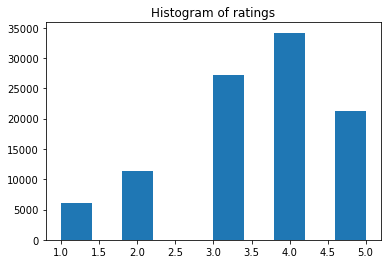

In [5]:
plt.hist(all_ratings.rating)
plt.title('Histogram of ratings')
plt.show()

In [6]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [7]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [8]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="images/rec_archi_1.svg" style="width: 600px;" />

In [9]:
from keras.layers import Input, Embedding, Flatten, merge, Dense, Dropout, Lambda
from keras.models import Model
import keras.backend as K
from keras_fixes import dot_mode

Using TensorFlow backend.


In [10]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = merge([user_vecs, item_vecs], mode=dot_mode, output_shape=(1,))

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [11]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

(80000,)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitely. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [12]:
ratings_train['rating'].shape

(80000,)

In [13]:
mae=np.mean(np.abs(ratings_train['rating']-initial_train_preds))
print("The MAE value is %.2f"%mae)
mse=np.mean((ratings_train['rating']-initial_train_preds)**2)
print("The MSE value is %.2f"%mse)

The MAE value is 3.53
The MSE value is 13.73


In [14]:
# %load solutions/compute_errors.py

### Monitoring runs

Keras enables to monitor various variables during training. 

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

In [15]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=6, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 5s - loss: 2.9138 - val_loss: 1.4506
Epoch 2/6
72000/72000 [==============================] - 4s - loss: 1.1128 - val_loss: 0.9951
Epoch 3/6
72000/72000 [==============================] - 6s - loss: 0.9466 - val_loss: 0.9476
Epoch 4/6
72000/72000 [==============================] - 4s - loss: 0.9212 - val_loss: 0.9345
Epoch 5/6
72000/72000 [==============================] - 4s - loss: 0.9125 - val_loss: 0.9296
Epoch 6/6
72000/72000 [==============================] - 4s - loss: 0.9090 - val_loss: 0.9268
Wall time: 29.9 s


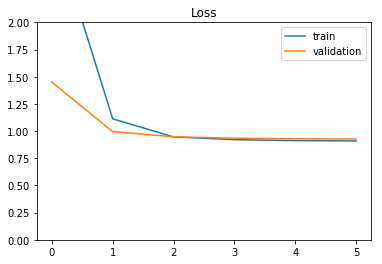

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

Now that the model is trained, the model MSE and MAE look nicer:

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 1.412
Final test MAE: 0.896


In [19]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 1.406
Final train MAE: 0.898


## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)

<img src="images/rec_archi_2.svg" style="width: 600px;" />


### Exercise

- The following code has **4 errors** that prevent it from working correctly. **Correct them and explain** why they are critical.

In [20]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
y = Dense(1)(x)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mean_absolute_error')

initial_train_preds = model.predict([user_id_train, item_id_train])

- the dropout rate was way too high, annihilating completely the majority of activations and resulting in a dramatic underfitting for the model;
- for the output layer, no activation function needs to be speficied, and there must be only one layer;
- our output is continuous, therefore we can't use the binary crossentropy loss, which is designed for classifications tasks.

In [21]:
# %load solutions/deep_explicit_feedback_recsys.py

In [22]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=10, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 6s - loss: 0.9764 - val_loss: 0.7629
Epoch 2/10
72000/72000 [==============================] - 6s - loss: 0.7477 - val_loss: 0.7573
Epoch 3/10
72000/72000 [==============================] - 6s - loss: 0.7354 - val_loss: 0.7559
Epoch 4/10
72000/72000 [==============================] - 6s - loss: 0.7250 - val_loss: 0.7476
Epoch 5/10
72000/72000 [==============================] - 6s - loss: 0.7157 - val_loss: 0.7407
Epoch 6/10
72000/72000 [==============================] - 6s - loss: 0.7081 - val_loss: 0.7396
Epoch 7/10
72000/72000 [==============================] - 6s - loss: 0.6994 - val_loss: 0.7366
Epoch 8/10
72000/72000 [==============================] - 6s - loss: 0.6941 - val_loss: 0.7339
Epoch 9/10
72000/72000 [==============================] - 6s - loss: 0.6886 - val_loss: 0.7324
Epoch 10/10
72000/72000 [==============================] - 6s - loss: 0.6834 - val_loss: 0.7312


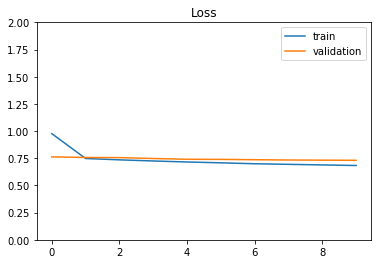

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [24]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.920
Final test MAE: 0.718


In [25]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.814
Final train MAE: 0.661


### Home assignment: 
 - Add another layer, compare train/test error
 - What do you notice? 
 - Try adding more dropout and modifying layer sizes: should you increase
   or decrease the number of parameters

##### Another layer
Let us add another layer and compare train and test errors. We chose to add the exact same layer.

In [26]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(0.2)(input_vecs)

x1 = Dense(64, activation='relu')(input_vecs)
x2 = Dense(64, activation='relu')(x1)
y = Dense(1)(x2)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mean_absolute_error')

initial_train_preds = model.predict([user_id_train, item_id_train])

In [27]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=10, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 6s - loss: 0.8914 - val_loss: 0.7649
Epoch 2/10
72000/72000 [==============================] - 7s - loss: 0.7451 - val_loss: 0.7556
Epoch 3/10
72000/72000 [==============================] - 6s - loss: 0.7270 - val_loss: 0.7464
Epoch 4/10
72000/72000 [==============================] - 7s - loss: 0.7143 - val_loss: 0.7412
Epoch 5/10
72000/72000 [==============================] - 7s - loss: 0.7049 - val_loss: 0.7393
Epoch 6/10
72000/72000 [==============================] - 6s - loss: 0.6965 - val_loss: 0.7429
Epoch 7/10
72000/72000 [==============================] - 6s - loss: 0.6887 - val_loss: 0.7392
Epoch 8/10
72000/72000 [==============================] - 6s - loss: 0.6837 - val_loss: 0.7379
Epoch 9/10
72000/72000 [==============================] - 7s - loss: 0.6788 - val_loss: 0.7421
Epoch 10/10
72000/72000 [==============================] - 6s - loss: 0.6735 - val_loss: 0.7411


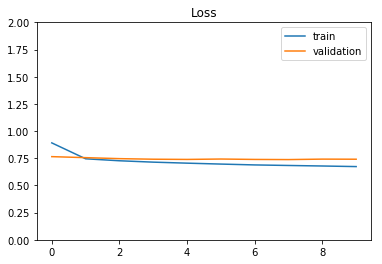

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [29]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.929
Final test MAE: 0.725


In [30]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.780
Final train MAE: 0.647


We added 5 epochs in order to let the 2-layer network have the time to converge efficiently.

When we look at the two plots giving the loss by epoch, we see that the two networks behave very similarly, both in terms of dynamics and of absolute level. However, we can see that at the end of the training session, the gap between the loss on the train and on the validation set tends to widen more quickly with the second network. We can hypothesize that adding a second layer may increase the overfitting of the model.

This hypothesis gets strengthened by the comparison of the metrics on the test sample, which are slightly smaller for the first network. On the contrary, the MSE and the MAE on the train subsample are smaller for the second layer.

##### More dropout

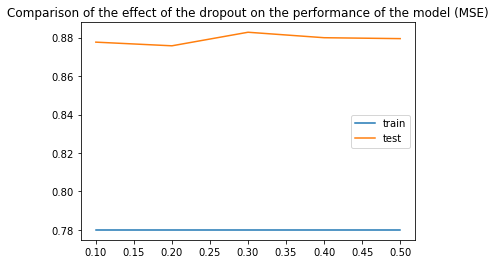

In [31]:
listOfDropouts=[0.1,0.2,0.3,0.4,0.5]

MSE_train=[]
MSE_test=[]

for dpsize in listOfDropouts:
    #Test of multiple dropouts
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')

    embedding_size = 30
    user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                               input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                               input_length=1, name='item_embedding')(item_id_input)

    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)

    input_vecs = merge([user_vecs, item_vecs], mode='concat')
    input_vecs = Dropout(dpsize)(input_vecs)

    x = Dense(64, activation='relu')(input_vecs)
    y = Dense(1)(x)

    model = Model(input=[user_id_input, item_id_input], output=y)
    model.compile(optimizer='adam', loss='mean_squared_error')

    initial_train_preds = model.predict([user_id_train, item_id_train])
    
    #Training with only 5 epochs for computational considerations
    history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True,verbose=False)
    
    #Compute predictions
    test_preds = model.predict([user_id_test, item_id_test])
    MSE_test.append(mean_squared_error(test_preds, rating_test))
    MSE_train.append(mean_squared_error(train_preds, rating_train))
    
#Plot the comparison
plt.plot(listOfDropouts,MSE_train,label="train")
plt.plot(listOfDropouts,MSE_test,label="test")
plt.legend(loc='best')
plt.title('Comparison of the effect of the dropout on the performance of the model (MSE)');

We can notice that the dropout strength does not affect much the train MSE. On the contrary, it has a quite important and non-linear impact on the test MSE. We see here that a dropout value of 0.3 seems to minimize the test loss; 0.1 might also be a good choice for this hyperparameter.

##### Varying the hidden layer size

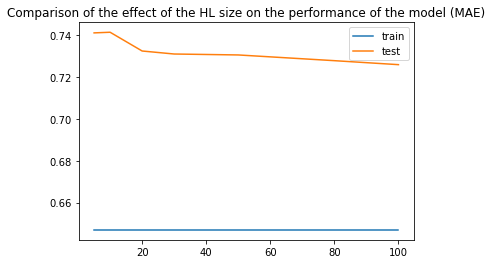

In [32]:
listOfSizes=[5,10,20,30,50,80,100]

MAE_train=[]
MAE_test=[]

for size in listOfSizes:
    #Test of sizes for the HL
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')

    embedding_size = 30
    user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                               input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                               input_length=1, name='item_embedding')(item_id_input)

    user_vecs = Flatten()(user_embedding)
    item_vecs = Flatten()(item_embedding)

    input_vecs = merge([user_vecs, item_vecs], mode='concat')
    input_vecs = Dropout(0.3)(input_vecs)

    x = Dense(size, activation='relu')(input_vecs)
    y = Dense(1)(x)

    model = Model(input=[user_id_input, item_id_input], output=y)
    model.compile(optimizer='adam', loss='mean_absolute_error')

    initial_train_preds = model.predict([user_id_train, item_id_train])
    
    #Training with only 5 epochs for computational considerations
    history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=5, validation_split=0.1,
                    shuffle=True,verbose=False)
    
    #Compute predictions
    test_preds = model.predict([user_id_test, item_id_test])
    MAE_test.append(mean_absolute_error(test_preds, rating_test))
    MAE_train.append(mean_absolute_error(train_preds, rating_train))
    
#Plot the comparison
plt.plot(listOfSizes,MAE_train,label="train")
plt.plot(listOfSizes,MAE_test,label="test")
plt.legend(loc='best')
plt.title('Comparison of the effect of the HL size on the performance of the model (MAE)');

Adding more neurons seems to decrease significantly the MAE metric. Adding more parameters has apparently a positive impact in our case.

In [33]:
# Rerun the initial model
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
y = Dense(1)(x)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mean_absolute_error')

initial_train_preds = model.predict([user_id_train, item_id_train])

In [34]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, nb_epoch=10, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 6s - loss: 0.9731 - val_loss: 0.7712
Epoch 2/10
72000/72000 [==============================] - 6s - loss: 0.7459 - val_loss: 0.7609
Epoch 3/10
72000/72000 [==============================] - 6s - loss: 0.7334 - val_loss: 0.7516
Epoch 4/10
72000/72000 [==============================] - 6s - loss: 0.7231 - val_loss: 0.7459
Epoch 5/10
72000/72000 [==============================] - 6s - loss: 0.7137 - val_loss: 0.7422
Epoch 6/10
72000/72000 [==============================] - 6s - loss: 0.7067 - val_loss: 0.7404
Epoch 7/10
72000/72000 [==============================] - 6s - loss: 0.7002 - val_loss: 0.7372
Epoch 8/10
72000/72000 [==============================] - 6s - loss: 0.6954 - val_loss: 0.7392
Epoch 9/10
72000/72000 [==============================] - 6s - loss: 0.6909 - val_loss: 0.7337
Epoch 10/10
72000/72000 [==============================] - 6s - loss: 0.6863 - val_loss: 0.7366


### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [35]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 30), (1683, 30), (60, 64), (64,), (64, 1), (1,)]

We have, by order of appearance:
- the embedding of the users (944,30)
- the embedding of the items (1683,30)
- the weights of the first hidden layer after the embedding (60,64)
- the biases for this layer (64,)
- the weights for the output (64,1)
- the bias for the output (1,)

In [36]:
# Solution: 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
user_embedding (Embedding)       (None, 1, 30)         28320       user[0][0]                       
____________________________________________________________________________________________________
item_embedding (Embedding)       (None, 1, 30)         50490       item[0][0]                       
___________________________________________________________________________________________

In [37]:
user_embeddings = weights[0]
item_embeddings = weights[1]
print("First item name from metadata:", items["name"][1])
print("Embedding vector for the first item:")
print(item_embeddings[1])
print("shape:", item_embeddings[1].shape)

First item name from metadata: Toy Story (1995)
Embedding vector for the first item:
[ 0.06853524 -0.10651002 -0.08404253 -0.07366705  0.09565089  0.06450953
  0.14598258 -0.0384788  -0.06857283  0.03434369 -0.06244737  0.12258478
  0.09527238  0.06823692  0.06828222 -0.04190949  0.09493763  0.05797443
 -0.10539429 -0.13896015 -0.08130277 -0.07954212  0.02619049 -0.00325702
  0.1043455   0.00698902  0.06517184 -0.08441726  0.05804263  0.06605052]
shape: (30,)


### Finding most similar items
Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space
- Write a function which computes the euclidean distance between a point in embedding space and all other points
- Write a most similar function, which returns the k item names with lowest euclidean distance
- Try with a movie index, such as 181 (Return of the Jedi). What do you observe? Don't expect miracles on such a small training set.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

In [47]:
EPSILON = 1e-07

def cosine(x, y):
    #TODO
    res = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
    return res

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    #TODO
    res=np.zeros(len(item_embeddings))
    for i in range(len(item_embeddings)):
        res[i]=np.linalg.norm(x-item_embeddings[i])
    return res

# Computes top_n most similar items to an idx
def most_similar(idx, top_n=10):
    # TODO: modify function
    idxs=np.argsort(euclidean_distances(item_embeddings[idx]))
    idxs = np.arange(1, top_n + 1)
    return items["name"][idxs]

most_similar(181, 10)

1                                      Toy Story (1995)
2                                      GoldenEye (1995)
3                                     Four Rooms (1995)
4                                     Get Shorty (1995)
5                                        Copycat (1995)
6     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
7                                 Twelve Monkeys (1995)
8                                           Babe (1995)
9                               Dead Man Walking (1995)
10                                   Richard III (1995)
Name: name, dtype: object

We observe that the 3 returned films from Toy Story do not strike as the closest in terms of content, type,... This is consistent with the size of the sample.

In [48]:
# %load solutions/similarity.py
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)

# Computes cosine similarities between x and all item embeddings
def cosine_similarities(x):
    dot_pdts = np.dot(item_embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(item_embeddings, axis=1)
    return dot_pdts / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Computes top_n most similar items to an idx, 
def most_similar(idx, top_n=10, mode='euclidean'):
    sorted_indexes=0
    if mode=='euclidean':
        dists = euclidean_distances(item_embeddings[idx])
        sorted_indexes = np.argsort(dists)
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], dists[idxs]))
    else:
        sims = cosine_similarities(item_embeddings[idx])
        # [::-1] makes it possible to reverse the order of a numpy
        # array, this is required because most similar items have
        # a larger cosine similarity value
        sorted_indexes = np.argsort(sims)[::-1]
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["name"][idxs], sims[idxs]))

# sanity checks:
print("cosine of item 1 and item 1: "
      + str(cosine(item_embeddings[1], item_embeddings[1])))
euc_dists = euclidean_distances(item_embeddings[1])
print(euc_dists.shape)
print(euc_dists[1:5])
print()

# Test on movie 181: Return of the Jedi
print("Items closest to 'Return of the Jedi':")
for title, dist in most_similar(181, mode="euclidean"):
    print(title, dist)


# We observe that the embedding is poor at representing similarities
# between movies, as most distance/similarities are very small/big 
# One may notice a few clusters though
# it's interesting to plot the following distributions
# plt.hist(euc_dists)

# The reason for that is that the number of ratings is low and the embedding
# does not automatically capture semantic relationships in that context. 
# Better representations arise with higher number of ratings, and less overfitting models


cosine of item 1 and item 1: 0.999999489957
(1683,)
[ 0.          0.55322742  0.61714333  0.40099573]

Items closest to 'Return of the Jedi':
Return of the Jedi (1983) 0.0
Glory (1989) 0.272495
Much Ado About Nothing (1993) 0.274298
GoodFellas (1990) 0.274401
Wedding Gift, The (1994) 0.276039
Guantanamera (1994) 0.280802
Nikita (La Femme Nikita) (1990) 0.282207
Paris Is Burning (1990) 0.289102
Ran (1985) 0.294622
Thin Man, The (1934) 0.302519


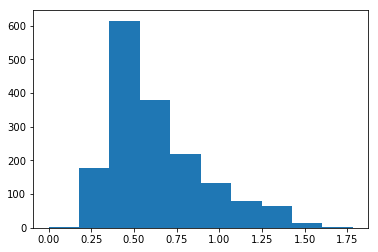

In [49]:
plt.hist(euc_dists)
plt.show()

### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

##### Different perplexities

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

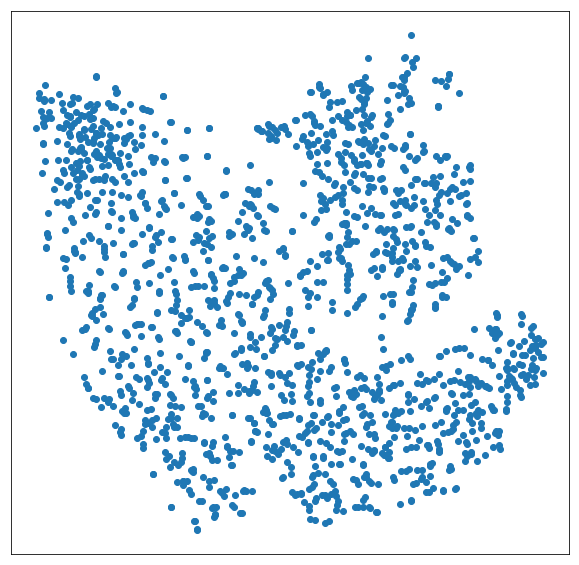

In [51]:
#Perplexity = 10
item_tsne = TSNE(perplexity=10).fit_transform(item_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

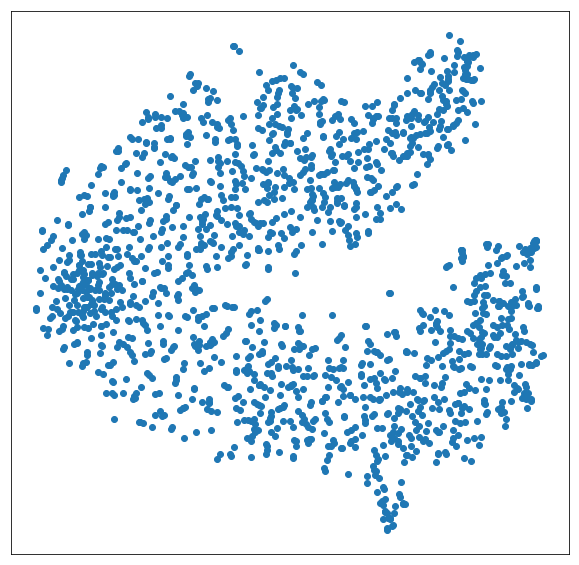

In [52]:
#Perplexity = 20
item_tsne = TSNE(perplexity=20).fit_transform(item_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

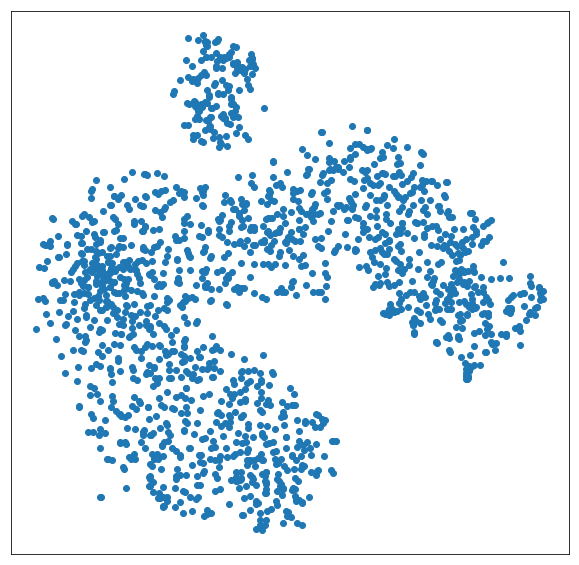

In [53]:
#Perplexity = 30
item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

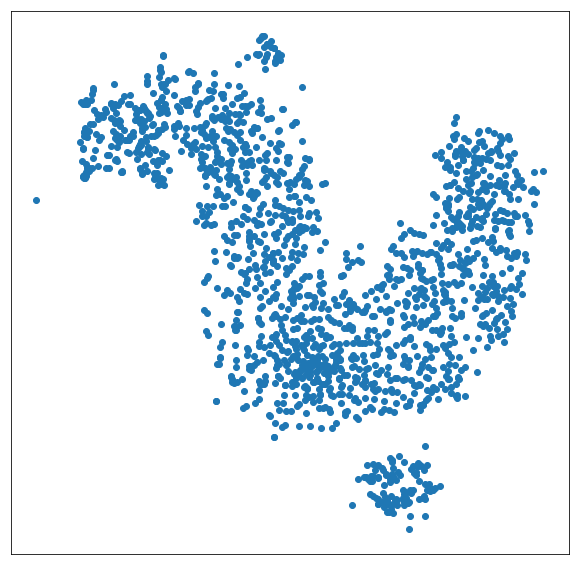

In [54]:
#Perplexity = 40
item_tsne = TSNE(perplexity=40).fit_transform(item_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

We remark that the perplexity parameter has a critical impact on the output of the t-SNE. In addition to that, we cannot detect any cluster of items thanks to the t-SNE.

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="images/rec_archi_3.svg" style="width: 600px;" />


In [55]:
# transform the date (string) into an int representing the release year
parsed_dates = [int(film_date[-4:])
                for film_date in items["date"].tolist()]

items['parsed_date'] = pd.Series(parsed_dates, index=items.index)
max_date = max(items['parsed_date'])
min_date = min(items['parsed_date'])

from sklearn.preprocessing import scale

items['scaled_date'] = scale(items['parsed_date'].astype('float64'))
item_meta_train = items["scaled_date"][item_id_train]
item_meta_test = items["scaled_date"][item_id_test]

len(item_meta_train), len(item_meta_test)

(80000, 20000)

In [56]:
items["scaled_date"].describe()

count    1.682000e+03
mean    -2.415758e-15
std      1.000297e+00
min     -4.730390e+00
25%      2.533563e-01
50%      3.937435e-01
75%      4.639372e-01
max      6.043244e-01
Name: scaled_date, dtype: float64

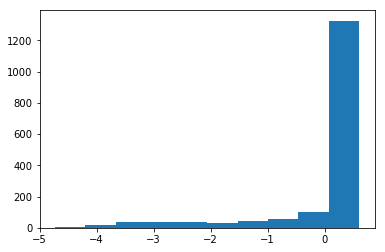

In [57]:
plt.hist(items.scaled_date)
plt.show()

In [58]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs, meta_input], mode='concat')

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)

model = Model(input=[user_id_input, item_id_input, meta_input], output=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train])

In [59]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, nb_epoch=15, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 7s - loss: 0.9480 - val_loss: 0.7727
Epoch 2/15
72000/72000 [==============================] - 7s - loss: 0.7633 - val_loss: 0.7566
Epoch 3/15
72000/72000 [==============================] - 7s - loss: 0.7408 - val_loss: 0.7597
Epoch 4/15
72000/72000 [==============================] - 7s - loss: 0.7188 - val_loss: 0.7426
Epoch 5/15
72000/72000 [==============================] - 7s - loss: 0.7013 - val_loss: 0.7376
Epoch 6/15
72000/72000 [==============================] - 6s - loss: 0.6897 - val_loss: 0.7344
Epoch 7/15
72000/72000 [==============================] - 7s - loss: 0.6805 - val_loss: 0.7345
Epoch 8/15
72000/72000 [==============================] - 7s - loss: 0.6728 - val_loss: 0.7359
Epoch 9/15
72000/72000 [==============================] - 7s - loss: 0.6673 - val_loss: 0.7303
Epoch 10/15
72000/72000 [==============================] - 7s - loss: 0.6616 - val_loss: 0.7299


In [60]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test Loss: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test Loss: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test Loss: 0.968
Final test Loss: 0.725


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [61]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_movies = list(all_ratings[all_ratings["user_id"]==user_id]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))
    
    print("user "+str(user_id) +" has seen "+str(len(seen_movies)) + " movies. "+
          "Computing ratings for "+str(len(item_ids))+ " other movies")
    
    item_ids = np.array(item_ids)
    user = np.zeros_like(item_ids)
    user[:]=user_id
    items_meta = items["scaled_date"][item_ids].values
    
    rating_preds = model.predict([user, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:,0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["name"][movie], rating_preds[movie][0]) for movie in rec_items]

In [64]:
recommend(100)

user 100 has seen 59 movies. Computing ratings for 1622 other movies


[('Innocent Sleep, The (1995)', 4.8690186),
 ('Nemesis 2: Nebula (1995)', 4.5701289),
 ('Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)',
  4.4307542),
 ('Prophecy, The (1995)', 4.4268513),
 ('Mondo (1996)', 4.4214711),
 ('Bushwhacked (1995)', 4.4206748),
 ('Hoodlum (1997)', 4.3798614),
 ('Monty Python and the Holy Grail (1974)', 4.3478069),
 ('Showgirls (1995)', 4.3441844),
 ('Maybe, Maybe Not (Bewegte Mann, Der) (1994)', 4.3244352)]

### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [65]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5], dtype=int64)

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

##### From regression to classification

In [66]:
#Change the output into a one-hot encoding representation
from keras.utils.np_utils import to_categorical
one_hot_rating_train = to_categorical(rating_train)
one_hot_rating_test = to_categorical(rating_test)

In [67]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs, meta_input], mode='concat')

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
y = Dense(6,activation="softmax")(x)

model = Model(input=[user_id_input, item_id_input, meta_input], output=y)
model.compile(optimizer='adam', loss='categorical_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train])

In [68]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train], one_hot_rating_train,
                    batch_size=64, nb_epoch=15, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 7s - loss: 1.3486 - val_loss: 1.2760
Epoch 2/15
72000/72000 [==============================] - 7s - loss: 1.2363 - val_loss: 1.2612
Epoch 3/15
72000/72000 [==============================] - 7s - loss: 1.2080 - val_loss: 1.2588
Epoch 4/15
72000/72000 [==============================] - 7s - loss: 1.1852 - val_loss: 1.2650
Epoch 5/15
72000/72000 [==============================] - 7s - loss: 1.1701 - val_loss: 1.2635
Epoch 6/15
72000/72000 [==============================] - 7s - loss: 1.1558 - val_loss: 1.2704
Epoch 7/15
72000/72000 [==============================] - 7s - loss: 1.1426 - val_loss: 1.2666
Epoch 8/15
72000/72000 [==============================] - 7s - loss: 1.1272 - val_loss: 1.2782
Epoch 9/15
72000/72000 [==============================] - 7s - loss: 1.1163 - val_loss: 1.2884
Epoch 10/15
72000/72000 [==============================] - 7s - loss: 1.1018 - val_loss: 1.2988


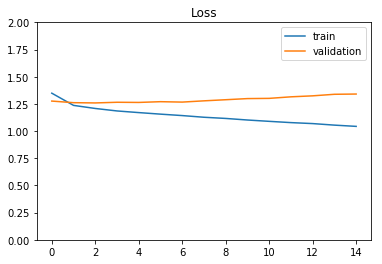

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

The network seems to overfit way more than before. Let us compute some more undersantable metrics:

In [70]:
test_preds = np.argmax(model.predict([user_id_test, item_id_test, item_meta_test]),axis=1)

print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 1.238
Final test MAE: 0.746


We use the same metrics as before so as to make the results comparable.

Here, the MAE seems relatively similar to the MAE of when we considered the problem as a regression problem. On the contrary, the MSE is larger : this is normal, because the MSE penalizes more the extreme errors, which are more probable here because we predict discrete values.

Random init MSE: 4.983
Random init MAE: 1.935
Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 7s - loss: 1.3624 - val_loss: 1.2886
Epoch 2/6
72000/72000 [==============================] - 6s - loss: 1.2824 - val_loss: 1.2747
Epoch 3/6
72000/72000 [==============================] - 6s - loss: 1.2623 - val_loss: 1.2697
Epoch 4/6
72000/72000 [==============================] - 6s - loss: 1.2517 - val_loss: 1.2648
Epoch 5/6
72000/72000 [==============================] - 6s - loss: 1.2438 - val_loss: 1.2573
Epoch 6/6
72000/72000 [==============================] - 6s - loss: 1.2381 - val_loss: 1.2581
Final test MSE: 1.131
Final test MAE: 0.710


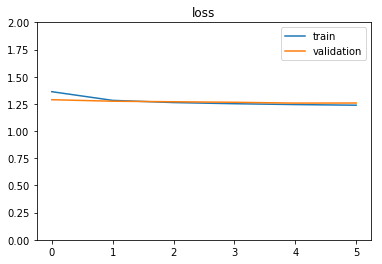

In [71]:
# %load solutions/classification.py
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 16
dense_size = 128
dropout_embedding = 0.5
dropout_hidden = 0.2

user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')
input_vecs = Dropout(dropout_embedding)(input_vecs)

x = Dense(dense_size, activation='relu')(input_vecs)
x = Dropout(dropout_hidden)(x)
x = Dense(dense_size, activation='relu')(x)
y = Dense(output_dim=5, activation='softmax')(x)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train]).argmax(axis=1) + 1
print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


history = model.fit([user_id_train, item_id_train], rating_train - 1,
                    batch_size=64, nb_epoch=6, validation_split=0.1,
                    shuffle=True)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('loss');

test_preds = model.predict([user_id_test, item_id_test]).argmax(axis=1) + 1
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
